In [2]:
import pandas as pd

# Load the data
data = pd.read_csv('../data/rating.csv')

# Preview the data
print(data.head())


   article_id source_id     source_name  \
0       81664       NaN          Forbes   
1       81667       NaN             CNA   
2       81694      time            Time   
3       81695       NaN        Phys.Org   
4       81703       NaN  Digital Trends   

                                              author  \
0  Elizabeth Brownfield, Contributor, \n Elizabet...   
1                                                NaN   
2                              Christina Larson / AP   
3                                       Sara Schmidt   
4                                       Jason Struss   

                                               title  \
0  superstar chef yannick alléno brings refined f...   
1  nice claim top spot in ligue 1 with late win a...   
2  amphibians are the world’s most vulnerable spe...   
3              image: rusty red waters in madagascar   
4  everything leaving max (formerly hbo max) in n...   

                                         description  \
0  Now open

In [3]:
import yake

# Initialize YAKE
language = "en"
max_ngram_size = 3
deduplication_threshold = 0.9
numOfKeywords = 10

yake_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

In [4]:
data['title_keywords'] = data['title'].apply(lambda x: yake_extractor.extract_keywords(x))
data['content_keywords'] = data['content'].apply(lambda x: yake_extractor.extract_keywords(x))

In [6]:
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer

def jaccard_similarity(list1, list2):
    # Convert keywords to sets
    set1 = set([kw[0] for kw in list1])
    set2 = set([kw[0] for kw in list2])
    
    # Calculate Jaccard similarity
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Apply Jaccard similarity to the dataset
data['keyword_similarity'] = data.apply(lambda row: jaccard_similarity(row['title_keywords'], row['content_keywords']), axis=1)


In [7]:
# Group by 'source_name' to see the average keyword similarity for each site
site_keyword_similarity = data.groupby('source_name')['keyword_similarity'].mean().reset_index()

# Display the results
print(site_keyword_similarity)

                     source_name  keyword_similarity
0                       ABC News            0.059437
1             Al Jazeera English            0.024143
2    AllAfrica - Top Africa News            0.035714
3                Android Central            0.033746
4                       BBC News            0.057400
5                    Boing Boing            0.039748
6               Business Insider            0.024637
7                            CNA            0.011004
8                            CNN            0.031768
9                       Deadline            0.044265
10                Digital Trends            0.058463
11                ETF Daily News            0.302659
12                      Euronews            0.011408
13                        Forbes            0.030328
14                   Gizmodo.com            0.016190
15            Globalsecurity.org            0.026332
16                 GlobeNewswire            0.102888
17  International Business Times            0.

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load the data
data = pd.read_csv('../data/rating.csv')

# Define a simple preprocessing function
def preprocess_text(text):
    # Convert to lowercase and remove stop words
    tokens = [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

# Apply preprocessing to the content column
data['cleaned_content'] = data['content'].apply(preprocess_text)

# Use CountVectorizer to create a term-document matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
term_matrix = vectorizer.fit_transform(data['cleaned_content'])

# Train the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(term_matrix)

# Extract topics and their top words
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print(" ".join([terms[i] for i in topic.argsort()[:-10 - 1:-1]]))

# Assign topics to documents
data['dominant_topic'] = lda.transform(term_matrix).argmax(axis=1)

topic_mapping = {
    0: 'Finance',
    1: 'Business',
    2: 'Politics',
    3: 'Geopolitics',
    4: 'Earnings',
    5: 'Sports',
    6: 'Stock Market',
    7: 'Technology',
    8: 'Market Analysis',
    9: 'International Relations',
}

# Map the dominant topics to categories
data['category'] = data['dominant_topic'].map(topic_mapping)

# Display the first few rows with the assigned categories
print(data[['title', 'category']].head())

Topic 0:
quarter according recent report free nyse filing company shares second
Topic 1:
2023 nov globe newswire market global billion company usd report
Topic 2:
year said india government house new state space years according
Topic 3:
israel 2023 gaza said president minister november state hamas ukraine
Topic 4:
report free nyse earnings reports quarter company owned shares nasdaq
Topic 5:
li ul world new year india cup time years said
Topic 6:
traded stock shares free report november trading high low thursday
Topic 7:
getty new images li ai ul ceo york 2023 photo
Topic 8:
report free research rating 00 nasdaq shares issued reports nyse
Topic 9:
2023 november china president people nov 11 republic 10 october
                                               title    category
0  superstar chef yannick alléno brings refined f...  Technology
1  nice claim top spot in ligue 1 with late win a...      Sports
2  amphibians are the world’s most vulnerable spe...    Business
3              image

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load the data
data = pd.read_csv('../data/rating.csv')

# Define a simple preprocessing function
def preprocess_text(text):
    tokens = [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

# Apply preprocessing to the content column
data['cleaned_content'] = data['content'].apply(preprocess_text)

# Use CountVectorizer to create a term-document matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
term_matrix = vectorizer.fit_transform(data['cleaned_content'])

# Train the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(term_matrix)

# Assign topics to documents
data['dominant_topic'] = lda.transform(term_matrix).argmax(axis=1)

# Analyze topic trends across websites
topic_counts = data.groupby(['source_name', 'dominant_topic']).size().unstack(fill_value=0)

# Calculate diversity as the number of different topics reported by each website
topic_diversity = topic_counts.apply(lambda x: (x > 0).sum(), axis=1).sort_values(ascending=False)

# Identify websites with the most diverse topics
most_diverse_websites = topic_diversity.head(10)

# Output the results
print("Websites with the most diverse topics:")
print(most_diverse_websites)

# Display the topics each website covers
print("\nTopic distribution by website:")
print(topic_counts.loc[most_diverse_websites.index])

# Analyze trends over time (handling mixed date formats)
if 'published_at' in data.columns:
    data['date'] = pd.to_datetime(data['published_at'], errors='coerce').dt.date
    # Drop rows where date conversion failed
    data = data.dropna(subset=['date'])
    topic_trends = data.groupby(['date', 'dominant_topic']).size().unstack(fill_value=0)
    print("\nTopic trends over time:")
    print(topic_trends)

Websites with the most diverse topics:
source_name
ABC News                        10
The Times of India              10
Marketscreener.com              10
GlobeNewswire                   10
Forbes                          10
International Business Times     9
The Punch                        9
The Indian Express               9
Phys.Org                         9
BBC News                         9
dtype: int64

Topic distribution by website:
dominant_topic                  0     1     2     3   4     5    6     7    8  \
source_name                                                                     
ABC News                        1    12   446   772   1   412    9   195    7   
The Times of India            230   367  1933  1129  14  1877  748   698  152   
Marketscreener.com             38   455   209   126  29   142   59   173    6   
GlobeNewswire                  65  4207    82    85  12   167   15   611    3   
Forbes                          6    56   252    99   3   807   11  

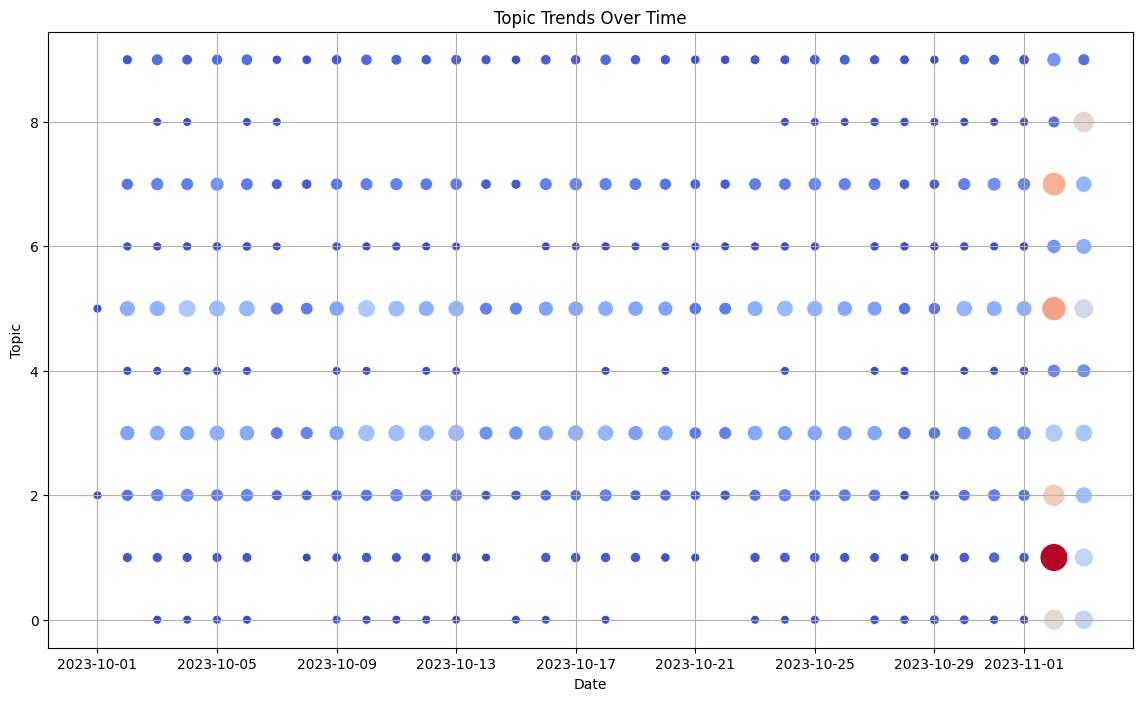

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load the data
data = pd.read_csv('../data/rating.csv')

# Define a simple preprocessing function
def preprocess_text(text):
    tokens = [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

# Apply preprocessing to the content column
data['cleaned_content'] = data['content'].apply(preprocess_text)

# Use CountVectorizer to create a term-document matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
term_matrix = vectorizer.fit_transform(data['cleaned_content'])

# Train the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(term_matrix)

# Assign topics to documents
data['dominant_topic'] = lda.transform(term_matrix).argmax(axis=1)

# Handle dates and analyze topic trends over time
if 'published_at' in data.columns:
    data['date'] = pd.to_datetime(data['published_at'], errors='coerce').dt.date
    data = data.dropna(subset=['date'])
    topic_trends = data.groupby(['date', 'dominant_topic']).size().reset_index(name='count')

    # Plot the 2D scatter plot
    plt.figure(figsize=(14, 8))
    scatter = sns.scatterplot(
        x='date', y='dominant_topic', size='count', hue='count', 
        palette='coolwarm', sizes=(40, 400), data=topic_trends, legend=None
    )
    
    plt.title('Topic Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Topic')
    plt.grid(True)
    plt.show()
